## Task II - Estimating Service Metrics from Device Statistics

Esse trecho devemos calcular estatisticas utilizando as metricas coletadas, utilizando modelos de aprendizagem de maquina. Sera treinado um modelo utilizando regressao linear e sera testando utilizando a tecnica *validation-set*.

1. Evaluate the Accuracy of Service Metric Estimation

    **a)** Model Training - use linear regression to train a model M with the training set. Provide the coefficients ($\theta_0, ..., \theta_9 $) of your model M.($\theta_0$ is the offset)
    
    **b)** Accuracy of Model M - compute the estimation error of M over the test set. We define the estimation error as the Normalized Mean Absolute Error (NMAE) = $\frac{1}{\bar{y}}(\frac{1}{m}\sum_{i=1}^{m} |y_i − \hat{y}_i |)$, whereby $\hat{y}_i$ is the model estimation for the measured service metric $y_i$ , and $\bar{y}$ is the average of the observations $y_i$ of the test set, which is of size m = 1080 [1]. Note that $\hat{y}_i = M(y_i)$. As a baseline for M, use a naı̈ve method which relies on Y values only. For each $x \in X$ it predicts a constant value $\bar{y}$ which is the sample mean of the samples $y_i$ in the training set. Compute $\bar{y}$ for the naı̈ve method for the training set and compute the NMAE for the test set.
    
    **c)** Produce a time series plot that shows both the measurements and the model estimations for M for the Video Frame Rate values in the test set (see example of such a plot in Figure 4(a) of [1]). Show also the prediction of the a naı̈ve method.
    
    **d)** Produce a density plot and a histogram for the Video Frame Rate values in the test set. Set the bin size of the histogram to 1 frame.
    
    **e)** Produce a density plot for the prediction errors $y_i − \hat{y}_i$ in the test set.
    
    **f)** Based on the above figures and graphs, discuss the accuracy of estimating the Video Frame Rate.

In [1]:
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as pp

x_data = pd.read_csv('./data/X.csv')
y_output = pd.read_csv('./data/Y.csv')

# Use 70% data for training and 30% for testing.
up_to = 2520
x_train, x_test, y_train, y_test = x_data[:up_to], x_data[up_to:], y_output[:up_to], y_output[up_to:]

# Create and train the model using the data.
model = linear_model.LinearRegression()
model.fit(x_train, y_train['DispFrames'])

# Predict some values.
y_pred = model.predict(x_test)

In [2]:
def absolute_errors(expected, found):
    return [abs(y1 - y2) for (y1, y2) in zip(expected, found)]

def mean_errors(expected, found):
    return sum(absolute_errors(expected, found)) / len(expected)

def normalized_mean_absolute_error(expected, found):
    return mean_errors(expected, found) / found.mean()

print('Calculated NMAE:', normalized_mean_absolute_error(y_test['DispFrames'], y_pred))


Calculated NMAE: 0.17470346406547052


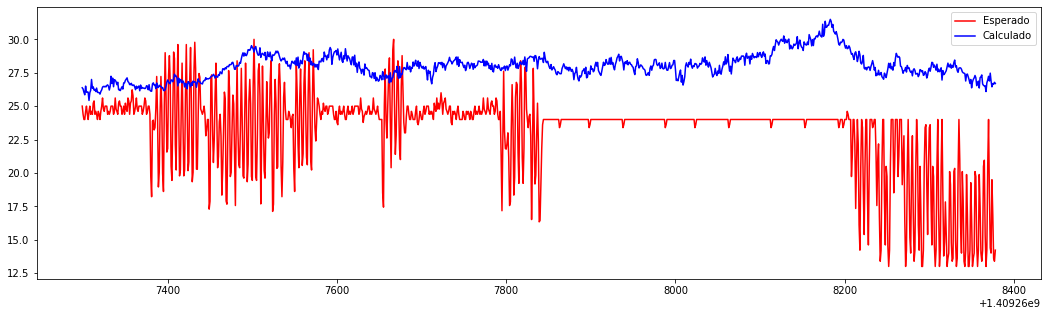

In [3]:
pp.figure(figsize=(18,5))

timestamps = y_test['TimeStamp']

pp.plot(timestamps, y_test['DispFrames'], 'r')
pp.plot(timestamps, y_pred, 'b')
pp.legend(['Esperado', 'Calculado'])
pp.show()

<AxesSubplot:ylabel='Density'>

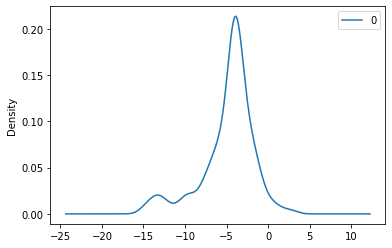

In [4]:
def prediction_errors(expected, output):
    return [yi - yhati for (yi, yhati) in zip(expected, output)]

pd.DataFrame(prediction_errors(y_test['DispFrames'], y_pred)).plot(kind='density')

Se baseando nos graficos gerados, pode ser notado que os valores previstos pelo modelo nao consegue se adequar propriamente aos valores coletados. A maior suspeita poderia ser pelo fato que um modelo de regressao linear nao consegue lidar com grandes variacoes, sendo mais moderado lidando com essas mudancas. Um modelo que consiga lidar melhor com variacoes abruptas poderia se adequar melhor ou alguma alteracao nos valores utilizados nos treinos.

### Parte 2

Sera analisado a relacao entre os dados utilizados no modelo e a acuracia obtida.

2. Study the Relationship between Estimation Accuracy and the Size of the Training Set

    **a)** From the above training set with 2520 observations, create six training sets by selecting uniformly at random 50, 100, 200, 500, 1000, and 2520 observations (which is the original set).
    
    **b)** Train a linear model and compute the *NMAE* for each model for the original test set with 1080 observations.
    
    **c)** Perform the above 50 times, so you train models for 50 different subsets of a given size.
    
    **d)** Produce a plot that shows *NMAE* for M against the size of the training set. Use error bars or box plots to show the range of the *NMAE* values for a given set size.
    
    **e)** Based on the above, discuss the relationship between the accuracy of the model estimations and the training set.

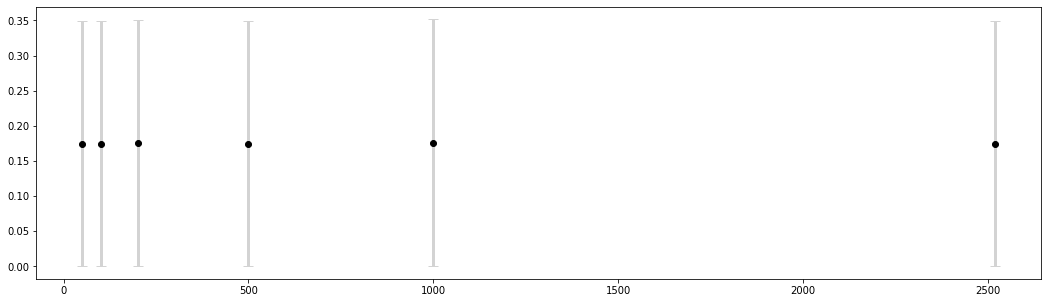

,Tamanho,NMAE
0,50,0.174533
1,100,0.174356
2,200,0.175114
3,500,0.174422
4,1000,0.175746
5,2520,0.174703


In [48]:
from sklearn.model_selection import train_test_split

def split_data(train_size):
    if up_to == train_size:
        return x_data[:up_to], x_data[up_to:], y_output[:up_to], y_output[up_to:]
    data_piece = x_data[:up_to]
    test_piece = y_output[:up_to]
    x_train, _, y_train, _ = train_test_split(data_piece, test_piece, test_size = train_size / len(data_piece))
    return x_train, x_data[up_to:], y_train, y_output[up_to:]

class Data:
    def __init__(self, train_size):
        self.size = train_size
        x_train, x_test, y_train, y_test = split_data(train_size)
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
class TrainedModel:
    def __init__(self, data):
        self.data = data
        self.model = linear_model.LinearRegression()
        self.predicted = []
        
    def train(self):
        self.model.fit(self.data.x_train, self.data.y_train['DispFrames'])
        
    def predict(self):
        self.predicted = self.model.predict(self.data.x_test)
        
    def calculate_nmae(self):
        return normalized_mean_absolute_error(self.data.y_test['DispFrames'], self.predicted)
    
train_sizes = [50, 100, 200, 500, 1000, 2520]
calculated_nmae = []

for size in train_sizes:
    nmae = 0
    for _ in range(50):
        model = TrainedModel(Data(size))
        model.train()
        model.predict()
        nmae += model.calculate_nmae()
    calculated_nmae.append((size, nmae / 50))
    
# Created 50 models for each train size and calculated the average NMAE.
# Now creating the errorbar plot of the size x NMAE.
pp.figure(figsize=(18,5))
for size, nmae in calculated_nmae:
    pp.errorbar(size, nmae, yerr = nmae, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=5)
    
pp.show()

pd.DataFrame(calculated_nmae, columns=["Tamanho", "NMAE"])

Pode ser observado pela figura e pela tabela que mesmo variando o tamanho dos dados de treinamento o NMAE nao sofreu nenhuma alteracao drastica. Talvez pelo fato de se tratar de uma regressao linear, alguns pontos de dados sao suficientes para o modelo, isso pode ser visto tambem pela outra figura do modelo anterior, que o modelo nao lida muito bem com uma flutuacao grande na predicao de resultados.

Como o modelo acaba sendo mais controlado em face de oscilacoes, com somente uma pequena parte dos dados ja se torna suficiente para o treinamento.